# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

# Load Dataset

In [2]:
path = './data/Debernardi et al 2020 data.csv'

df_orig = pd.read_csv(path)

df_orig.head()

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


# Clean Dataset

In [3]:
df_clean = df_orig.copy()

# Replace NaNs in 'stage' with 0 (no cancer)
df_clean[['stage']] = df_clean[['stage']].fillna(value=0)

# Drop the 'benign_sample_diagnosis' (let's just figure out if it is cancer or not)
df_clean = df_clean.drop(labels='benign_sample_diagnosis', axis=1)

# Drop 'patient_cohort'
df_clean = df_clean.drop(labels='patient_cohort', axis=1)

# Drop 'sample_origin'
df_clean = df_clean.drop(labels='sample_origin', axis=1)

df_clean.head()

,sample_id,age,sex,diagnosis,stage,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,33,F,1,0,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,81,F,1,0,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,51,M,1,0,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,61,M,1,0,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,62,M,1,0,9.0,0.21489,0.000860,65.54000,41.088000,NaN


# Explore

## Check for NaNs; we will fix these later

These missing values are due to differences in data collection methodology. We will impute to mean by group (control, benign, cancer).

In [9]:
print(df_clean.isna().sum())

sample_id          0
age                0
sex                0
diagnosis          0
stage              0
plasma_CA19_9    240
creatinine         0
LYVE1              0
REG1B              0
TFF1               0
REG1A            284
dtype: int64


## Find outliers

### Check for monoclonal antibody outliers

I think we can ignore the obvious issues (looks like things were misrecorded by an order of magnitude in some of those) in the cancer group as it appears that elevated plasma_CA19_9 is positivley correlated with cancer (with a couple of ignorable outliers in the benign category).

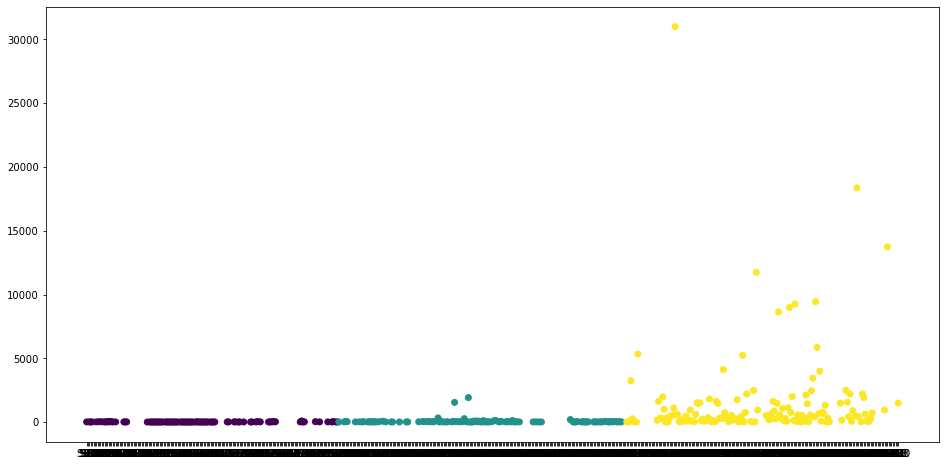

In [5]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df_clean['sample_id'], df_clean['plasma_CA19_9'], c=df_clean['diagnosis'])
plt.show()

### Check for outliers in creatinine

Nothing actionable here.

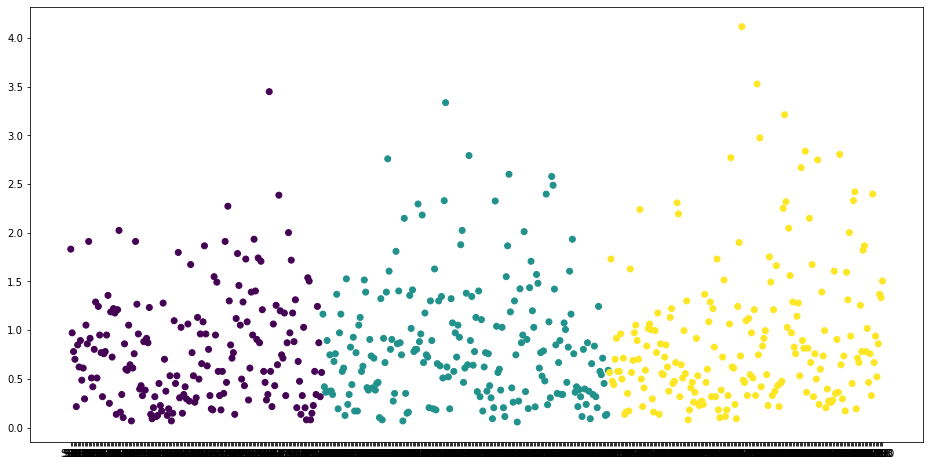

In [11]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df_clean['sample_id'], df_clean['creatinine'], c=df_clean['diagnosis'])
plt.show()

### Check for outliers in LYVE1

From here I think one of the cancer group is clearly entered wrong, I think it is the same egregious one as in the 'plasma_CA19_9' plot.

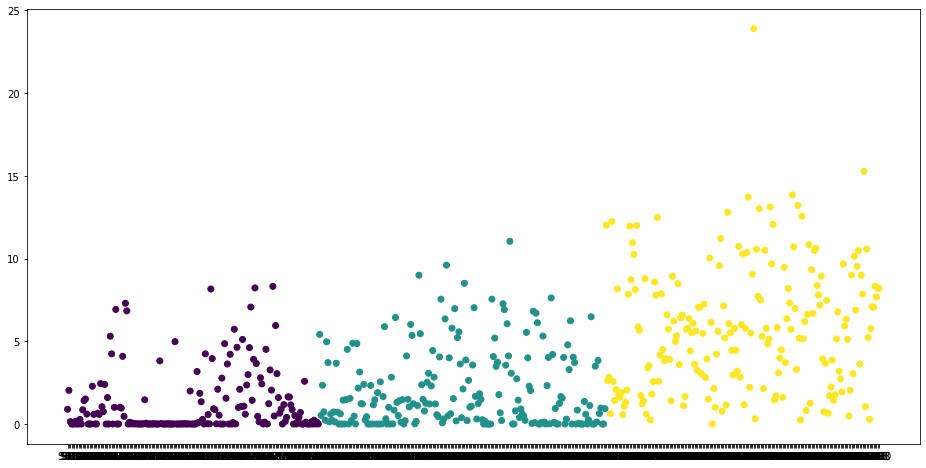

In [12]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df_clean['sample_id'], df_clean['LYVE1'], c=df_clean['diagnosis'])
plt.show()